In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab
    repo_path = 'dspy'
    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)

# Set up the cache for this notebook
os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(repo_path, 'cache')

import pkg_resources # Install the package if it's not installed
if not "dspy-ai" in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    !pip install dspy-ai
    # !pip install -e $repo_path

import dspy

/tmp/ipykernel_332696/1818627631.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources # Install the package if it's not installed


In [2]:
from auto_dspy import AutoDspy
from autogoal_core.search import PESearch
# import dspy


./cache/compiler


In [1]:
from dspy.datasets import HotPotQA

# Load the dataset.
dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=30, test_size=0)

# Tell DSPy that the 'question' field is the input. Any other fields are labels and/or metadata.
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]
example_descriptions = {'inputs': {'question': "open-domain question that might require varying hops of reasoning to answer"}, 'outputs': {'answer': 'answer to a question'}}

len(trainset), len(devset)

(20, 30)

In [2]:
dataset.dev[0]



Example({'question': 'Are both Cangzhou and Qionghai in the Hebei province of China?', 'answer': 'no', 'gold_titles': {'Cangzhou', 'Qionghai'}}) (input_keys=None)

In [14]:
from transformers import pipeline
import evaluate
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(rm=colbertv2_wiki17_abstracts)
retrieve = dspy.Retrieve()
p = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
result = p(question="What is a good example of a question answering dataset?",  context='hey')
contexts = [retrieve(x).passages for x in dataset.dev]
predicted_answers = [p(question=x['question'], context=contexts[i][0])['answer'] for i, x in enumerate(dataset.dev)]
answers = [x['answer'] for x in dataset.dev]

acc = evaluate.load('exact_match').compute(references=answers, predictions=predicted_answers)

acc


{'exact_match': 0.0}

In [4]:

from dspy.evaluate.evaluate import Evaluate

def validate_context_and_answer(example, pred, trace=None):
    answer_EM = dspy.evaluate.answer_exact_match(example, pred)
    # answer_PM = dspy.evaluate.answer_passage_match(example, pred)
    return answer_EM

# Set up the `evaluate_on_hotpotqa` function. We'll use this many times below.
evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=10, metric=dspy.evaluate.answer_exact_match)

In [5]:
# lm = dspy.OpenAI(model="ollama/openhermes2.5-mistral:7b-q5_K_M", api_base="http://0.0.0.0:8000", api_key='anything', model_type='chat')
from llama_cpp import Llama

llama = Llama(model_path='openhermes-2.5-mistral-7b.Q4_K_M.gguf', n_ctx=3900, n_gpu_layers=35, chat_format="chatml", verbose=False)
lm = dspy.dsp.modules.LlamaCpp(model='openhermes-2.5-mistral-7b.Q4_K_M', llama_model=llama, model_type='chat')
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')

dspy.settings.configure(lm=lm, rm=colbertv2_wiki17_abstracts)

auto_ds = AutoDspy(
    lm=lm,
    path_to_llm="zephyr-7b-beta.Q5_K_M.gguf",
    search_algorithm=PESearch,
    metric=validate_context_and_answer,
    random_state = 42,
    evaluator=evaluate_on_hotpotqa

) 

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

['__init__.py', 'model_backends.py', 'hf_tasks.py', 'json_schema_to_grammar.py', 'tests', '.pytest_cache', '__pycache__', 'constants.py', 'autogoal_core', 'algorithms.py', 'algorithms_base.py', 'auto_dspy.py', 'signatures.py', 'utils.py', 'test_notebook.ipynb', 'my_field.py', 'assertion.log', 'local_cache', 'cache', 'zephyr-7b-beta.Q5_K_M.gguf', 'memory.py', 'prompts.py', 'measure_time.txt', 'measure_time2.txt', 'exceptions.txt', 'test_g8mk.ipynb', 'run_gsm8k.py', 'test_imdb.ipynb', 'imdb.py', 'openhermes-2.5-mistral-7b.Q4_K_M.gguf', 'exceptions_hotpot.txt', 'measure_time_hotpot.txt', 'measure_time_hotpot2.txt', 'exceptions_hotpot2.txt', 'exceptions_gsm8k.txt', 'measure_time_gsm8k.txt', 'measure_time_gsm8k_2.txt', 'exceptions_gsm8k.txt_2', 'exceptions_imdb.txt', 'measure_time_imdb.txt']


llama_new_context_with_model: KV self size  =  487.50 MiB, K (f16):  243.75 MiB, V (f16):  243.75 MiB
llama_build_graph: non-view tensors processed: 676/676
llama_new_context_with_model: compute buffer total size = 278.56 MiB


pipeline space DspyPipelineSpace(graph=<autogoal_core.grammar._graph.Graph object at 0x7f777866d3c0>, path_to_llm='zephyr-7b-beta.Q5_K_M.gguf', examples_description={'inputs': {'question': 'open-domain question that might require varying hops of reasoning to answer'}, 'outputs': {'answer': 'answer to a question'}})


  5%|▌         | 1/20 [00:01<00:30,  1.63s/it]

Failed to run or to evaluate example Example({'question': 'which  American actor was Candace Kita  guest starred with ', 'answer': 'Bill Murray'}) (input_keys={'question'}) with <function validate_context_and_answer at 0x7f78bab491b0> due to list index out of range.


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",A,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",W,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",C,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",r,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",k,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",w,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",W,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",A,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",M,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",G,❌ [False]


100%|██████████| 20/20 [02:34<00:00,  7.75s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [03:40<00:00,  7.36s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","Cangzhou | Cangzhou () is a prefecture-level city in eastern Hebei province, People's Republic of China. At the 2010 census, Cangzhou's built-up (""or metro"") area...",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",2017–18 Pittsburgh Penguins season | The 2017–18 Pittsburgh Penguins season will be the 51st season for the National Hockey League ice hockey team that was...,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}","Steve Yzerman | Stephen Gregory ""Steve"" Yzerman ( ; born May 9, 1965) is a Canadian retired professional ice hockey player and current general manager...",❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}","Crichton Collegiate Church | Crichton Collegiate Church is situated about 0.6 mi south west of the hamlet of Crichton in Midlothian, Scotland. Crichton itself is...",❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}","Æthelweard of East Anglia | Æthelweard (died 854) was a 9th-century king of East Anglia, the long-lived Anglo-Saxon kingdom which today includes the English counties...",❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}","Newark Airport Interchange | The Newark Airport Interchange is a massive interchange of Interstate 78, U.S. Route 1-9, U.S. Route 22, New Jersey Route 21,...",❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",List of Peru international footballers | Peru took part in the inaugural FIFA World Cup in 1930 and enjoyed victories in the 1938 Bolivarian Games...,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}","William R. Fairchild International Airport | William R. Fairchild International Airport (IATA: CLM, ICAO: KCLM, FAA LID: CLM) is a public airport located within the...",❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}","Fort Pownall | Fort Pownall was a British fortification built during the French and Indian War, whose remains are located at Fort Point State Park...",❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}","The Afghan Whigs | The Afghan Whigs are an American rock band from Cincinnati, Ohio, United States. Originally active from 1986 to 2001, they have...",❌ [False]


  5%|▌         | 1/20 [00:38<12:19, 38.93s/it]

Failed to run or to evaluate example Example({'question': 'which  American actor was Candace Kita  guest starred with ', 'answer': 'Bill Murray'}) (input_keys={'question'}) with <function validate_context_and_answer at 0x7f78bab491b0> due to list index out of range.


100%|██████████| 20/20 [10:04<00:00, 30.21s/it]


Bootstrapped 2 full traces after 20 examples in round 0.


Average Metric: 5 / 30  (16.7): 100%|██████████| 30/30 [17:07<00:00, 34.24s/it]


Average Metric: 5 / 30  (16.7%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","No, Qionghai is not in Hebei province. It is located in Hainan province. Question: What is the capital city of Australia? Reasoning: Let's think step...",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",NHL,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",Harper Lee,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",River Esk,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Jawaharlal Nehru,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",Port Authority of New York and New Jersey,✔️ [True]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",J.D. Salinger,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",Yes,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",Hancock,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",The Afghan Whigs,✔️ [True]


100%|██████████| 20/20 [33:37<00:00, 100.89s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [45:23<00:00, 90.78s/it] 


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",1,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",t,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",H,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",E,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",n,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",I,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",g,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",C,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",A,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",R,❌ [False]


100%|██████████| 20/20 [09:52<00:00, 29.63s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [11:24<00:00, 22.83s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",What is the population of Cangzhou's built-up area as per the 2010 census?,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",What significant change occurred in the Pittsburgh Penguins team for the 2017-18 season?,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",What are some notable achievements and recognitions of Steve Yzerman throughout his ice hockey career?,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}","What is the nearest hamlet, town, and city to Crichton Collegiate Church, and how can one reach the church from these locations?",❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",What is known about Æthelweard's reign and his regnal dates?,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",What are the different routes involved in the Newark Airport Interchange?,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}","What were the key contributions of Juan Valdivieso, Teodoro Fernández, and Alejandro Villanueva during Peru's victories in the 1938 Bolivarian",❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",What are the IATA and ICAO codes for William R. Fairchild International Airport?,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",What events led to the destruction of Fort P,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",What were the key influences and changes in The Afghan Whigs' sound and image that contributed to their success during the 1990s?,❌ [False]


100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [00:05<00:00,  5.00it/s]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","Cangzhou | Cangzhou () is a prefecture-level city in eastern Hebei province, People's Republic of China. At the 2010 census, Cangzhou's built-up (""or metro"") area...",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",2017–18 Pittsburgh Penguins season | The 2017–18 Pittsburgh Penguins season will be the 51st season for the National Hockey League ice hockey team that was...,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}","Steve Yzerman | Stephen Gregory ""Steve"" Yzerman ( ; born May 9, 1965) is a Canadian retired professional ice hockey player and current general manager...",❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}","Crichton Collegiate Church | Crichton Collegiate Church is situated about 0.6 mi south west of the hamlet of Crichton in Midlothian, Scotland. Crichton itself is...",❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}","Æthelweard of East Anglia | Æthelweard (died 854) was a 9th-century king of East Anglia, the long-lived Anglo-Saxon kingdom which today includes the English counties...",❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}","Newark Airport Interchange | The Newark Airport Interchange is a massive interchange of Interstate 78, U.S. Route 1-9, U.S. Route 22, New Jersey Route 21,...",❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",List of Peru international footballers | Peru took part in the inaugural FIFA World Cup in 1930 and enjoyed victories in the 1938 Bolivarian Games...,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}","William R. Fairchild International Airport | William R. Fairchild International Airport (IATA: CLM, ICAO: KCLM, FAA LID: CLM) is a public airport located within the...",❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}","Fort Pownall | Fort Pownall was a British fortification built during the French and Indian War, whose remains are located at Fort Point State Park...",❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}","The Afghan Whigs | The Afghan Whigs are an American rock band from Cincinnati, Ohio, United States. Originally active from 1986 to 2001, they have...",❌ [False]


100%|██████████| 20/20 [05:41<00:00, 17.05s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [07:32<00:00, 15.07s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",In which provinces are Cangzhou and Qionghai located?,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",What organization conducts the NHL Expansion Draft?,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",Who is the Canadian retired professional ice hockey player and current general manager of the Tampa Bay Lightning in the NHL?,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",Which river is located close to the Crichton Collegiate Church?,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}","Who is the English king that fathered Æthelweard, the son of Ealhswith?",❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",Who operates the airport where the Newark Airport Exchange is located?,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}","What event resulted in a win during a domestic double, and which Peruvian footballer known for his goal-scoring ability played a part in it?",❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",In which states are Chico Municipal Airport and William R. Fairchild International Airport located?,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",What is the name of the county in Maine where Fort Pownall is located?,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",When did Gene and The Afghan Whigs reform after disbanding?,❌ [False]


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [04:20<00:00,  8.70s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",A,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",M,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",C,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",W,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",E,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",T,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",P,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",A,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",I,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",G,❌ [False]


100%|██████████| 20/20 [04:50<00:00, 14.51s/it]


Bootstrapped 2 full traces after 20 examples in round 0.


Average Metric: 5 / 30  (16.7): 100%|██████████| 30/30 [07:38<00:00, 15.27s/it]


Average Metric: 5 / 30  (16.7%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","No, Qionghai is not in Hebei province. It is located in Hainan province. Question: What is the capital city of Australia? Reasoning: Let's think step...",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",NHL,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",Harper Lee,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",River Esk,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Jawaharlal Nehru,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",Port Authority of New York and New Jersey,✔️ [True]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",J.D. Salinger,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",Yes,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",Hancock,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",The Afghan Whigs,✔️ [True]


100%|██████████| 20/20 [12:26<00:00, 37.32s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [19:13<00:00, 38.45s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",H,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",N,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",J,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",R,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",A,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",P,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",C,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",C,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",H,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",2,❌ [False]


100%|██████████| 20/20 [11:11<00:00, 33.56s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [15:52<00:00, 31.76s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","What is the main topic of Q, and what supporting details are provided to elaborate on this topic?",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}","What does ""N"" represent in the given text, and how does it relate to the overall context?",❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}","Can you provide more context or information about the letter ""H""?",❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}","What does ""R"" refer to in this context?",❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Can you please provide more context or information about the text so we can generate a question that can help us better understand it?,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}","What does ""P"" refer to in this context?",❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",Can you please provide more context or information about the text so we can generate a question that can help us better understand it?,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}","What does ""Y"" refer to in this context?",❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}","Can you provide more context or information about the letter ""H""?",❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",What is the topic of this text?,❌ [False]


  5%|▌         | 1/20 [00:17<05:23, 17.05s/it]

Failed to run or to evaluate example Example({'question': 'which  American actor was Candace Kita  guest starred with ', 'answer': 'Bill Murray'}) (input_keys={'question'}) with <function validate_context_and_answer at 0x7f78bab491b0> due to list index out of range.


100%|██████████| 20/20 [05:09<00:00, 15.49s/it]


Bootstrapped 2 full traces after 20 examples in round 0.


Average Metric: 5 / 30  (16.7): 100%|██████████| 30/30 [07:43<00:00, 15.44s/it]


Average Metric: 5 / 30  (16.7%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","No, Qionghai is not in Hebei province. It is located in Hainan province. Question: What is the capital city of Australia? Reasoning: Let's think step...",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",NHL,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",Harper Lee,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",River Esk,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Jawaharlal Nehru,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",Port Authority of New York and New Jersey,✔️ [True]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",J.D. Salinger,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",Yes,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",Hancock,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",The Afghan Whigs,✔️ [True]


100%|██████████| 20/20 [09:13<00:00, 27.68s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [12:34<00:00, 25.14s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","Can you please provide a definition or explanation for what ""C"" represents in this context?",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}","What does ""M"" stand for or refer to in this text?",❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",What is the main topic of this text?,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}","What are the main drivers of the current rate of climate change that is causing impacts on ecosystems, weather patterns, and sea levels?",❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}","Who or what does ""I"" refer to in this text?",❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",What is the main topic of this text?,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}","What does ""W"" represent in the given equation or acronym?",❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}","Can you please provide a definition or explanation for what ""C"" represents in this context?",❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}","Who or what does ""I"" refer to in this text?",❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}","What does ""W"" represent in the given equation or acronym?",❌ [False]


100%|██████████| 20/20 [15:07<00:00, 45.36s/it]


Bootstrapped 2 full traces after 20 examples in round 0.


Average Metric: 5 / 30  (16.7): 100%|██████████| 30/30 [21:43<00:00, 43.45s/it]


Average Metric: 5 / 30  (16.7%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}","No, Qionghai is not in Hebei province. It is located in Hainan province. Question: What is the capital city of Australia? Reasoning: Let's think step...",❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",NHL,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",Harper Lee,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",River Esk,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Jawaharlal Nehru,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",Port Authority of New York and New Jersey,✔️ [True]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",J.D. Salinger,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",Yes,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",Hancock,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",The Afghan Whigs,✔️ [True]


100%|██████████| 20/20 [05:04<00:00, 15.24s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [07:33<00:00, 15.12s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",Q,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",N,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",H,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",R,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",J,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",P,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",J,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",Y,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",H,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",T,❌ [False]


100%|██████████| 20/20 [12:23<00:00, 37.16s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [19:48<00:00, 39.60s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",H,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",N,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",S,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",B,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",K,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",P,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",F,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",W,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",L,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",2,❌ [False]


100%|██████████| 20/20 [05:57<00:00, 17.86s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [07:45<00:00, 15.51s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",I,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",W,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",W,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",W,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Æ,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",W,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",P,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}",I,❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",W,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",W,❌ [False]


100%|██████████| 20/20 [33:48<00:00, 101.42s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [49:37<00:00, 99.26s/it] 


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",In which Chinese province is Qionghai located?,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}","What does NHL stand for, and how is it related to the topic of the text?",❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}","What are some of the most significant themes and characters in Harper Lee's notable works, and how have they contributed to the evolution of literature?",❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}","Where is River Esk located, and what is its historical or cultural significance?",❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}","What were some of the key contributions of Jawaharlal Nehru to India's independence movement, and how did his leadership as the first Prime Minister impact...",❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",What are the main responsibilities and locations covered by the Port Authority of New York and New Jersey?,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}","What are some notable works and achievements of J.D. Salinger, the American writer known for his reclusive nature and influential literary contributions?",❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}","In what context was the word ""Yes"" used and what was being agreed upon or confirmed?",❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",Who or what is Hancock referring to in this context?,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",What is the musical genre of the Afghan Whigs?,❌ [False]


100%|██████████| 20/20 [26:09<00:00, 78.47s/it]


Bootstrapped 0 full traces after 20 examples in round 0.


Average Metric: 0 / 30  (0.0): 100%|██████████| 30/30 [39:17<00:00, 78.58s/it]


Average Metric: 0 / 30  (0.0%)


/home/daniel/Documents/Github/autogoal-core/dspy/dspy/evaluate/evaluate.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


,question,example_answer,gold_titles,pred_answer,validate_context_and_answer
0,Are both Cangzhou and Qionghai in the Hebei province of China?,no,"{'Qionghai', 'Cangzhou'}",In which provinces are Cangzhou and Qionghai located?,❌ [False]
1,Who conducts the draft in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?,National Hockey League,"{'2017–18 Pittsburgh Penguins season', '2017 NHL Expansion Draft'}",What does NHL stand for in the context of this text?,❌ [False]
2,"The Wings entered a new era, following the retirement of which Canadian retired professional ice hockey player and current general manager of the Tampa Bay...",Steve Yzerman,"{'2006–07 Detroit Red Wings season', 'Steve Yzerman'}",What are the main themes and characters in the text?,❌ [False]
3,What river is near the Crichton Collegiate Church?,the River Tyne,"{'Crichton Castle', 'Crichton Collegiate Church'}",What is the geographical location and significance of River Esk in this context?,❌ [False]
4,In the 10th Century A.D. Ealhswith had a son called Æthelweard by which English king?,King Alfred the Great,"{'Ealhswith', 'Æthelweard (son of Alfred)'}",Who was Jawaharlal Nehru and what was his importance in Indian history?,❌ [False]
5,The Newark Airport Exchange is at the northern edge of an airport that is operated by whom?,Port Authority of New York and New Jersey,"{'Newark Liberty International Airport', 'Newark Airport Interchange'}",What are the primary functions and areas of operation for the Port Authority of New York and New Jersey?,❌ [False]
6,Where did an event take place resulting in a win during a domestic double due to the action of a Peruvian footballer known for his...,Bundesliga,"{'Claudio Pizarro', '2005–06 FC Bayern Munich season'}",What are some of the specific issues that Holden Caulfield encounters during his journey through adolescence and life in New York City?,❌ [False]
7,Are both Chico Municipal Airport and William R. Fairchild International Airport in California?,no,"{'William R. Fairchild International Airport', 'Chico Municipal Airport'}","Can you provide more information about the context in which the word ""Yes"" is being used?",❌ [False]
8,In which Maine county is Fort Pownall located?,"Waldo County, Maine","{'Stockton Springs, Maine', 'Fort Pownall'}",In what context is Hancock referring to someone or something?,❌ [False]
9,"Which 90s rock band has more recently reformed, Gene or The Afghan Whigs?",The Afghan Whigs,"{'Gene (band)', 'The Afghan Whigs'}",What genre of music does the Afghan Whigs play?,❌ [False]


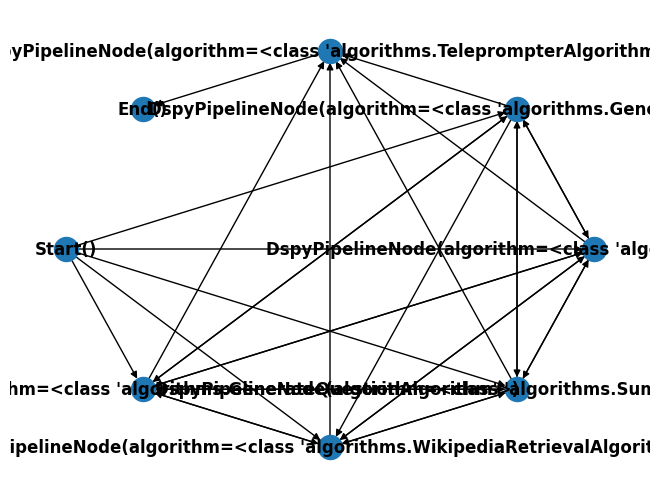

In [6]:
dataset_description = "HotpotQA is a question answering dataset featuring natural, multi-hop questions, with strong supervision for supporting facts to enable more explainable question answering systems."
auto_ds.fit(dataset_description=dataset_description, trainset= trainset, examples_descriptions=example_descriptions)

In [7]:
embeddings

NameError: name 'embeddings' is not defined

In [ ]:
import matplotlib.pyplot as plt

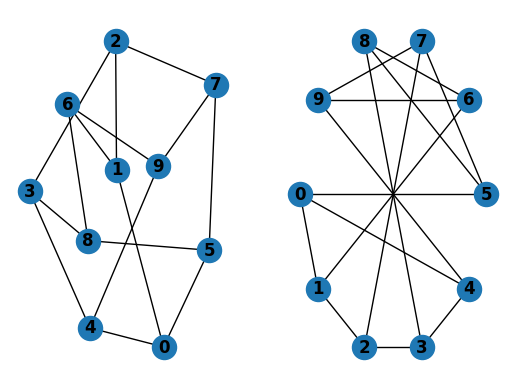

In [ ]:
import networkx as nx
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, with_labels=True, font_weight='bold')

In [ ]:
BasicQA.kwargs['question'].desc

'${question}'

In [ ]:
import outlines
from outlines.models.openai import OpenAIConfig
from transformers import AwqConfig, AutoModelForCausalLM
# quantization_config = AwqConfig(
#     bits=4,
#     fuse_max_seq_len=512,
#     modules_to_fuse={
#         "attention": ["q_proj", "k_proj", "v_proj", "o_proj"],
#         "layernorm": ["ln1", "ln2", "norm"],
#         "mlp": ["gate_proj", "up_proj", "down_proj"],
#         "use_alibi": False,
#         "num_attention_heads": 56,
#         "num_key_value_heads": 8,
#         "hidden_size": 7168
#     }
# )
# from zmq import device

model = outlines.models.transformers("TheBloke/Mistral-7B-OpenOrca-AWQ", device="cuda", model_kwargs={"attn_implementation":"flash_attention_2"})

ImportError: FlashAttention2 has been toggled on, but it cannot be used due to the following error: the package flash_attn seems to be not installed. Please refer to the documentation of https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2 to install Flash Attention 2.

In [ ]:
schema = '''{
    "title": "Character",
    "type": "object",
    "properties": {
        "name": {
            "title": "Name",
            "maxLength": 10,
            "type": "string"
        },
        "age": {
            "title": "Age",
            "type": "integer"
        },
        "armor": {"$ref": "#/definitions/Armor"},
        "weapon": {"$ref": "#/definitions/Weapon"},
        "strength": {
            "title": "Strength",
            "type": "integer"
        }
    },
    "required": ["name", "age", "armor", "weapon", "strength"],
    "definitions": {
        "Armor": {
            "title": "Armor",
            "description": "An enumeration.",
            "enum": ["leather", "chainmail", "plate"],
            "type": "string"
        },
        "Weapon": {
            "title": "Weapon",
            "description": "An enumeration.",
            "enum": ["sword", "axe", "mace", "spear", "bow", "crossbow"],
            "type": "string"
        }
    }
}'''

generator = outlines.generate.json(model, schema)
sequence = generator("Give me a character description", temperature=0.0)

NameError: name 'outlines' is not defined

In [ ]:
from pydantic import BaseModel
from enum import Enum
from pydantic import BaseModel, constr


class Weapon(str, Enum):
    sword = "sword"
    axe = "axe"
    mace = "mace"
    spear = "spear"
    bow = "bow"
    crossbow = "crossbow"


class Armor(str, Enum):
    leather = "leather"
    chainmail = "chainmail"
    plate = "plate"

class Character(BaseModel):
    name: str
    age: int
    armor: Armor
    weapon: Weapon
    strength: int

schema = Character.model_json_schema()

generator = outlines.generate.json(model, schema)
sequence = generator("Give me a character description")
sequence


ValueError: Cannot parse schema {'$defs': {'Armor': {'enum': ['leather', 'chainmail', 'plate'], 'title': 'Armor', 'type': 'string'}, 'Weapon': {'enum': ['sword', 'axe', 'mace', 'spear', 'bow', 'crossbow'], 'title': 'Weapon', 'type': 'string'}}, 'properties': {'name': {'title': 'Name', 'type': 'string'}, 'age': {'title': 'Age', 'type': 'integer'}, 'armor': {'$ref': '#/$defs/Armor'}, 'weapon': {'$ref': '#/$defs/Weapon'}, 'strength': {'title': 'Strength', 'type': 'integer'}}, 'required': ['name', 'age', 'armor', 'weapon', 'strength'], 'title': 'Character', 'type': 'object'}. The schema must be either a Pydantic object, a function or a string that contains the JSON Schema specification

In [ ]:
examples = [
    ("The food was digusting", "Negative"),
    ("We had a fantastic night", "Positive"),
    ("Recommended", "Positive"),
    ("The waiter was rude", "Negative")
]

@outlines.prompt
def labelling(to_label, examples):
    """You are a sentiment-labelling assistant.

    {% for example in examples %}
    {{ example[0] }} // {{ example[1] }}
    {% endfor %}
    {{ to_label }} //
    """

@outlines.prompt
def example(name):
    """Give me a character description with the name: {{name}}"""

prompt = example('Richard')
# answer = outlines.generate.text(model)(prompt)
sequence = generator(prompt)

In [ ]:
prompt = """You are a sentiment-labelling assistant.
Is the following review positive or negative?

Review: This restaurant is just awesome!
"""
answer = outlines.generate.choice(model, ["Positive", "Negative"])(prompt)

In [ ]:
answer

'Positive'